# Importing Libraries

In [19]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from PIL import Image
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from pytorch_lightning import Trainer
from torch.utils.data import random_split


In [81]:
label_colors = {
    0: (255, 0, 0),       # Rojo intenso
    1: (0, 100, 0),       # Verde oscuro
    2: (0, 0, 128),       # Azul marino
    3: (255, 215, 0),     # Oro
    4: (148, 0, 211),     # Violeta oscuro
    5: (255, 165, 0),     # Naranja
    6: (0, 255, 255),     # Cian
    7: (255, 20, 147),    # Rosa intenso
    8: (139, 69, 19),     # Marrón
    9: (30, 144, 255)     # Azul dodger
}

In [82]:
# Clase para colorear las imágenes de MNIST en un dataset
class ColoredMNISTWrapper(Dataset):
    def __init__(self, base_dataset, label_colors):
        self.base_dataset = base_dataset
        self.label_colors = {k: torch.tensor(v, dtype=torch.float32) / 255 for k, v in label_colors.items()}

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]  # [1, 28, 28]
        color = self.label_colors[label]
        img = img.repeat(3, 1, 1) * color.view(3, 1, 1)
        return img, label


In [83]:
mnist_dataset = MNIST(root="./mnist", train=True, transform=ToTensor(), download=True)

In [84]:
class ColoredMNISTSegmentationDataset(Dataset):
    def __init__(self, colored_dataset, num_digits=5, image_size=112, max_tries=20, num_images=50000):
        self.colored_dataset = colored_dataset
        self.num_digits = num_digits
        self.image_size = image_size
        self.max_tries = max_tries
        self.num_images = num_images

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        bg_img = torch.zeros(3, self.image_size, self.image_size)
        mask = torch.zeros(self.image_size, self.image_size, dtype=torch.long)
        occupancy = torch.zeros(self.image_size, self.image_size, dtype=torch.bool)  

        placed_digits = 0
        attempts = 0

        while placed_digits < self.num_digits and attempts < self.max_tries:
            rand_idx = torch.randint(0, len(self.colored_dataset), (1,)).item()
            digit_img, label = self.colored_dataset[rand_idx]
            digit_mask = (digit_img.sum(dim=0) > 0)

            x = torch.randint(0, self.image_size - 28, (1,)).item()
            y = torch.randint(0, self.image_size - 28, (1,)).item()

            target_area = occupancy[y:y+28, x:x+28]
            overlap = target_area & digit_mask

            if not overlap.any(): 
                bg_img[:, y:y+28, x:x+28] = torch.where(
                    digit_mask.unsqueeze(0),
                    digit_img,
                    bg_img[:, y:y+28, x:x+28]
                )

                mask[y:y+28, x:x+28] = torch.where(
                    digit_mask,
                    (label + 1),  
                    mask[y:y+28, x:x+28]
                )

                occupancy[y:y+28, x:x+28] |= digit_mask
                placed_digits += 1

            attempts += 1

        return bg_img, mask


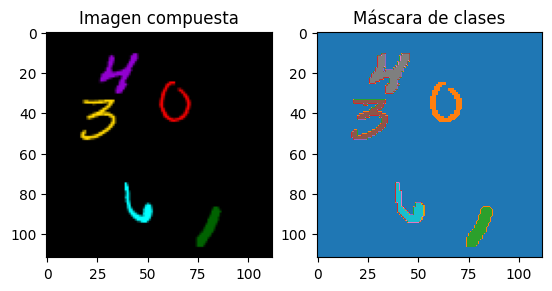

In [85]:
sample_dataset = ColoredMNISTWrapper(mnist_dataset, label_colors)

sample_data = ColoredMNISTSegmentationDataset(sample_dataset, num_digits=5, image_size=112)

img, mask = sample_data[1]
plt.subplot(1, 2, 1)
plt.title("Imagen compuesta")
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title("Máscara de clases")
plt.imshow(mask, cmap='tab10')  # cmap tab10 para clases 0-9
plt.show()

# Crear carpetas si no existen
os.makedirs("samples", exist_ok=True)
os.makedirs("masks_sample", exist_ok=True)

# Guardar imágenes y máscaras
for idx in range(5):
    img, mask = sample_data[idx]  # img: [3, H, W], mask: [H, W]

    # Guardar imagen RGB
    save_image(img, f"samples/img_{idx:04d}.png")


    mask_img = to_pil_image(mask.byte())  # Convertir a imagen PIL, importante que sea byte
    mask_img.save(f"masks_sample/mask_{idx:04d}.png")


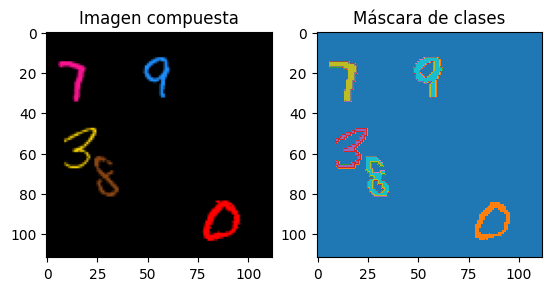

In [96]:
colored_train_dataset = ColoredMNISTWrapper(mnist_dataset, label_colors)

segmentation_dataset = ColoredMNISTSegmentationDataset(colored_train_dataset, num_digits=5, image_size=112)

img, mask = segmentation_dataset[1]
plt.subplot(1, 2, 1)
plt.title("Imagen compuesta")
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title("Máscara de clases")
plt.imshow(mask, cmap='tab10')  # cmap tab10 para clases 0-9
plt.show()


In [57]:
# Crear carpetas si no existen
os.makedirs("images", exist_ok=True)
os.makedirs("masks", exist_ok=True)

# Guardar imágenes y máscaras
for idx in tqdm(range(len(segmentation_dataset))):
    img, mask = segmentation_dataset[idx]  # img: [3, H, W], mask: [H, W]

    # Guardar imagen RGB
    save_image(img, f"images/img_{idx:04d}.png")


    mask_img = to_pil_image(mask.byte())  # Convertir a imagen PIL, importante que sea byte
    mask_img.save(f"masks/mask_{idx:04d}.png")


100%|██████████| 50000/50000 [03:15<00:00, 256.36it/s]


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Cargar imagen y máscara
        image = Image.open(os.path.join(self.image_dir, self.image_filenames[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, self.mask_filenames[idx]))

        # Aplicar transformaciones si existen
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [3]:
img_transform = T.Compose([
    T.ToTensor(),  # Convierte [H, W, C] → [C, H, W]
    T.Normalize([0.5]*3, [0.5]*3),  # Normaliza RGB entre -1 y 1 (opcional)
])

mask_transform = T.Compose([
    T.PILToTensor(),  # da [1, H, W]
    T.Lambda(lambda x: x.squeeze(0)),  # Convierte [1, H, W] → [H, W]
])


In [4]:
dataset = SegmentationDataset("images", "masks", transform_img=img_transform, transform_mask=mask_transform)

In [5]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [6]:
print(f"Total dataset size: {total_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Total dataset size: 50000
Train set size: 40000
Validation set size: 5000
Test set size: 5000


In [26]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16,num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0)

Training Batch Samples:


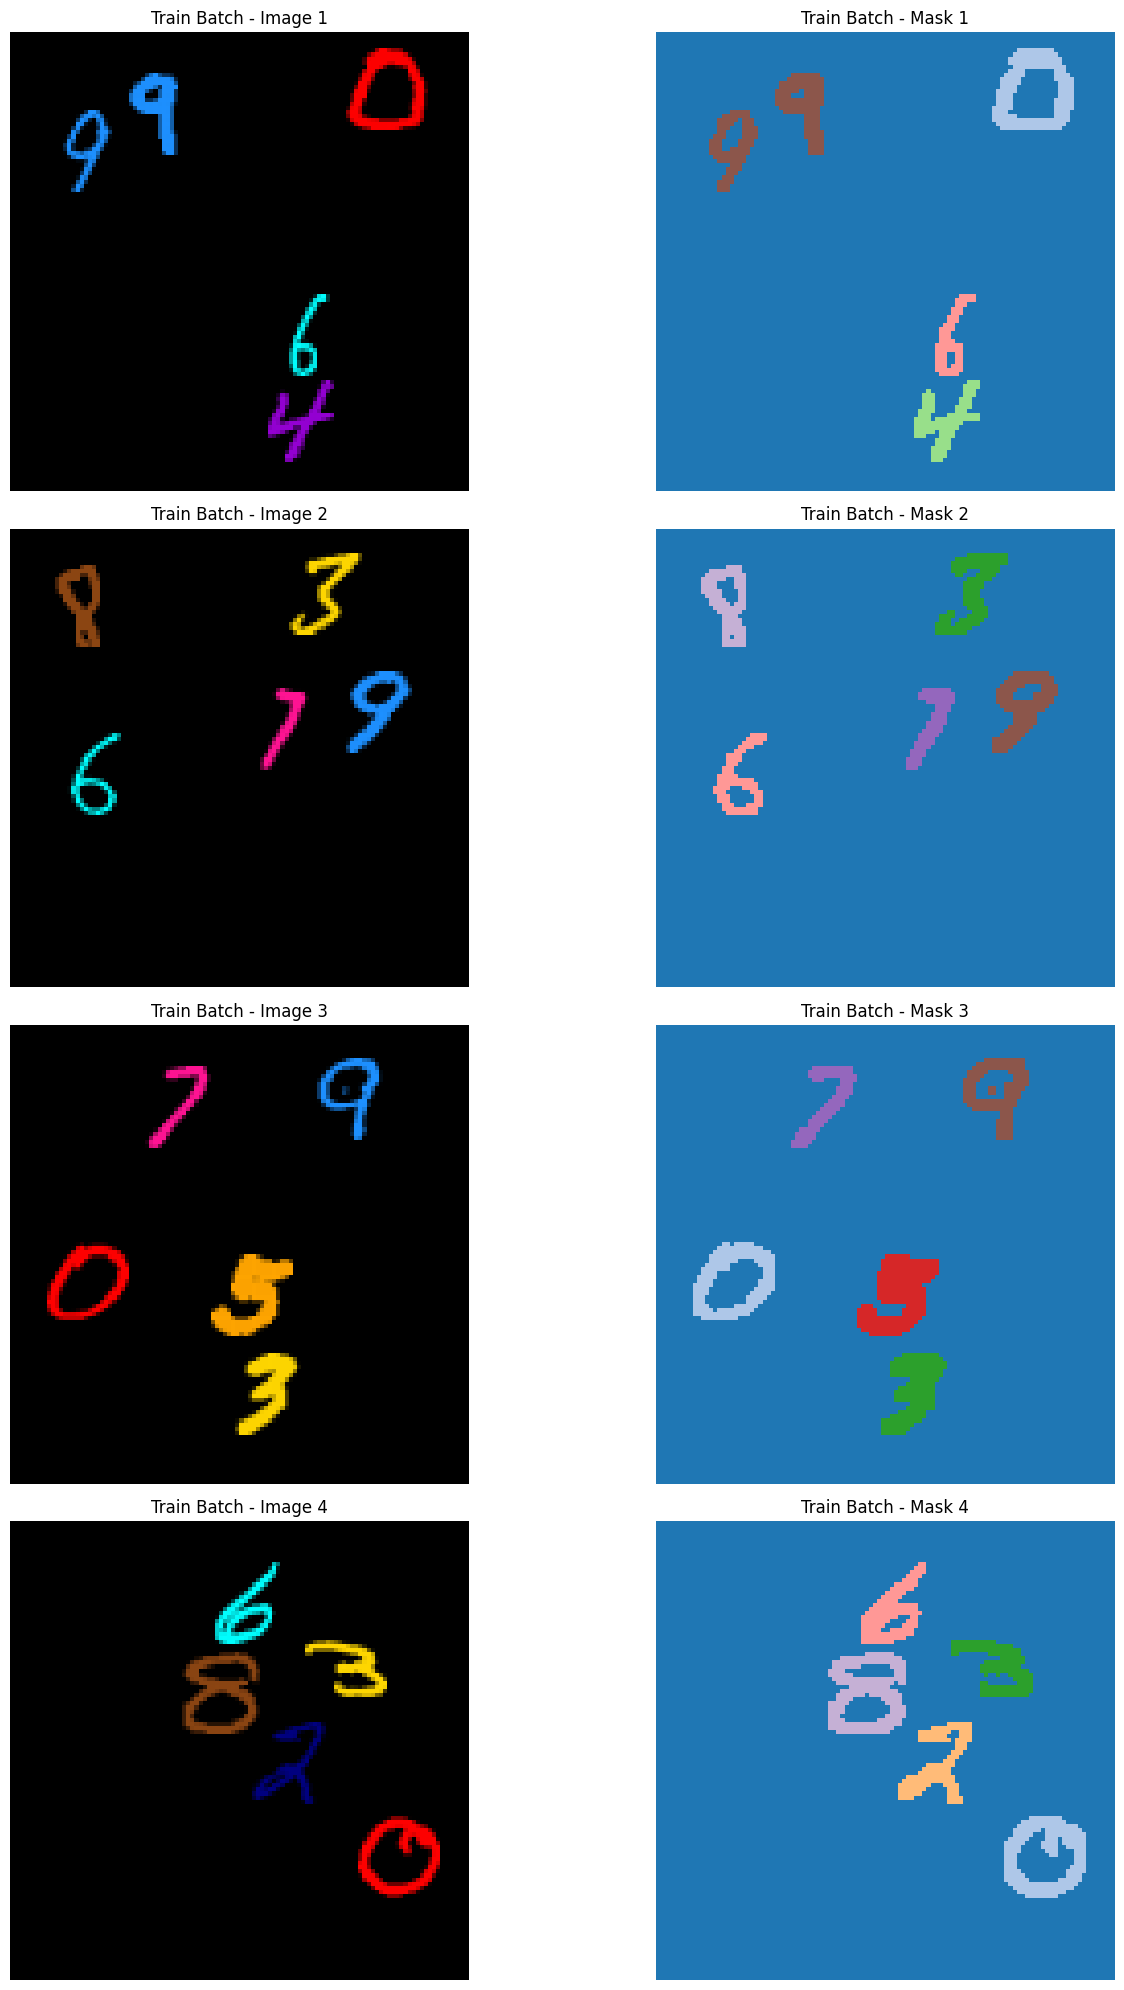


Validation Batch Samples:


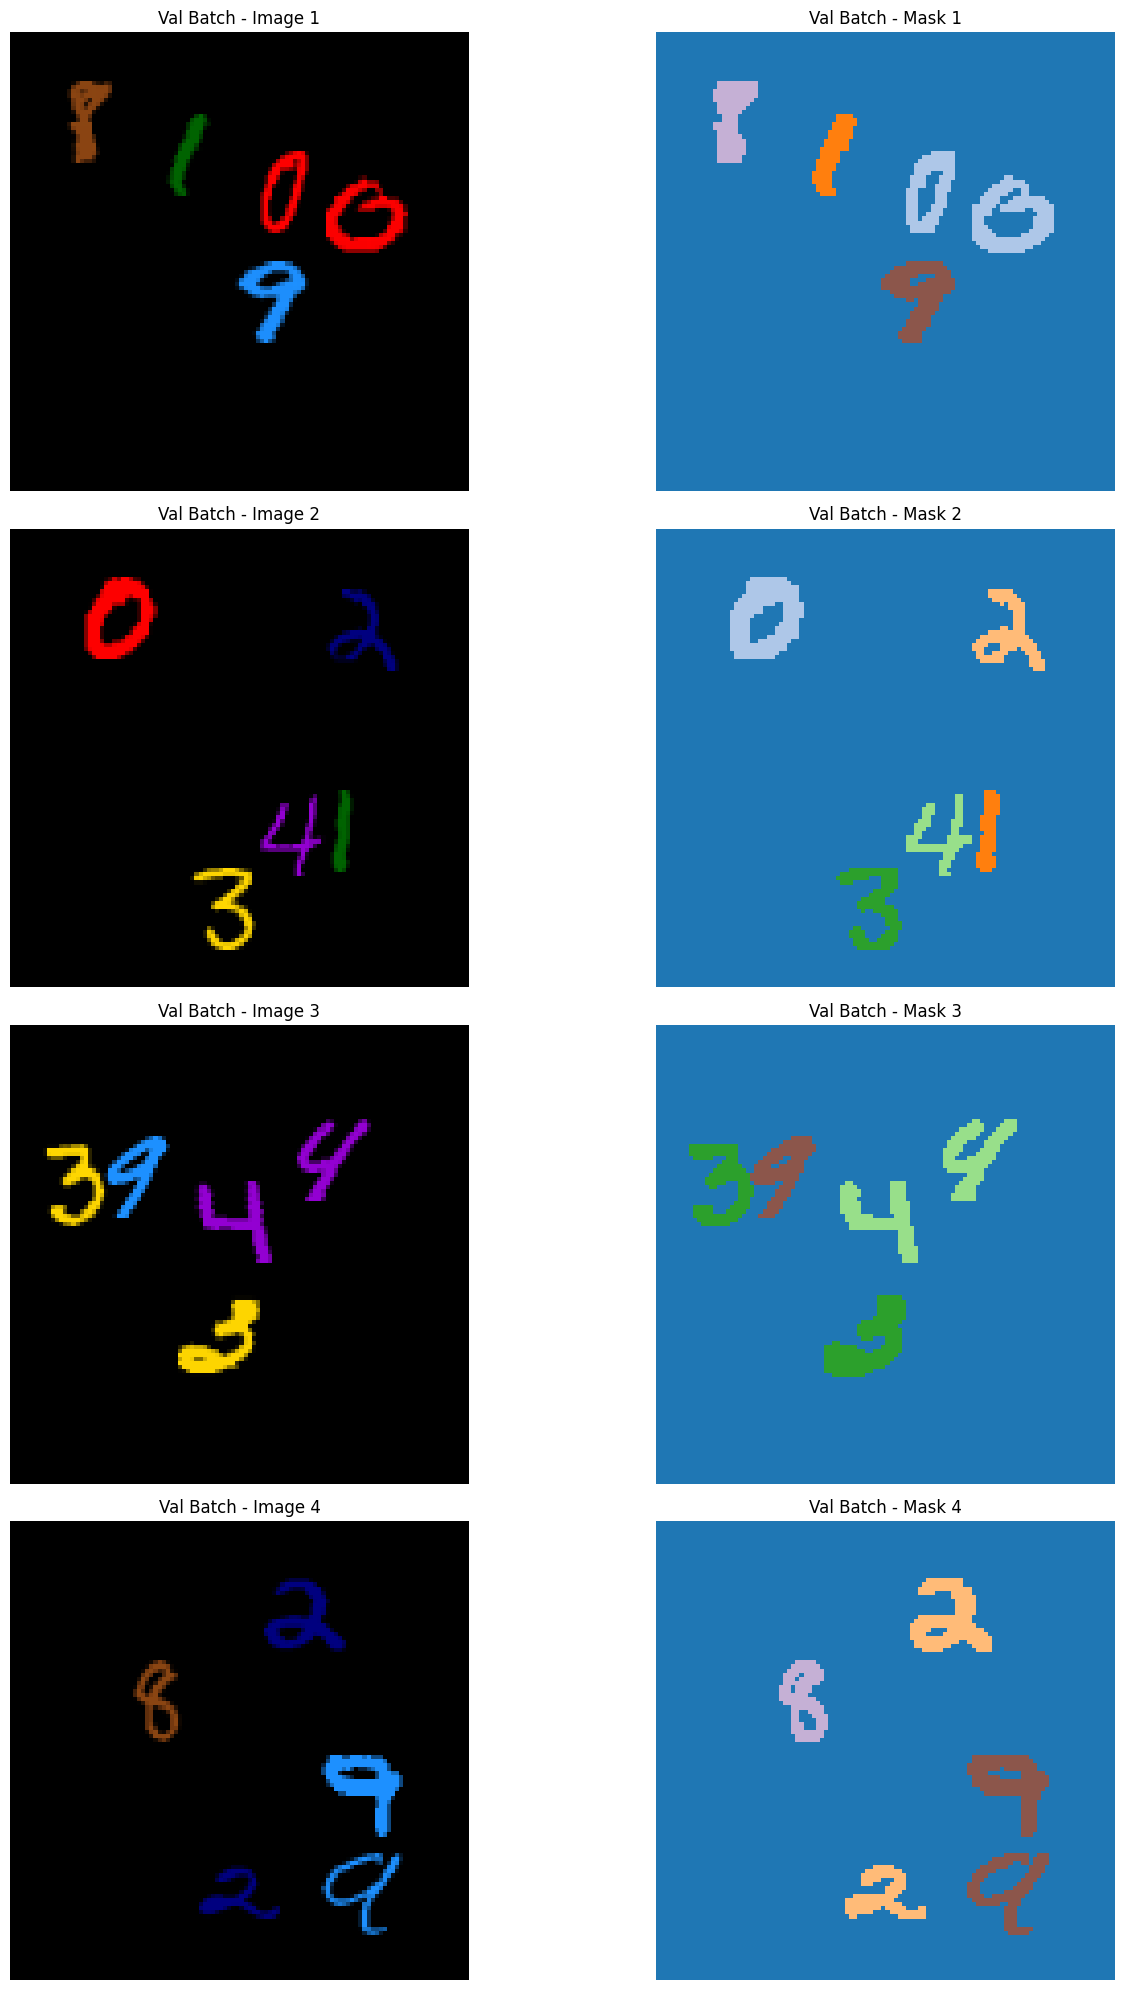


Test Batch Samples:


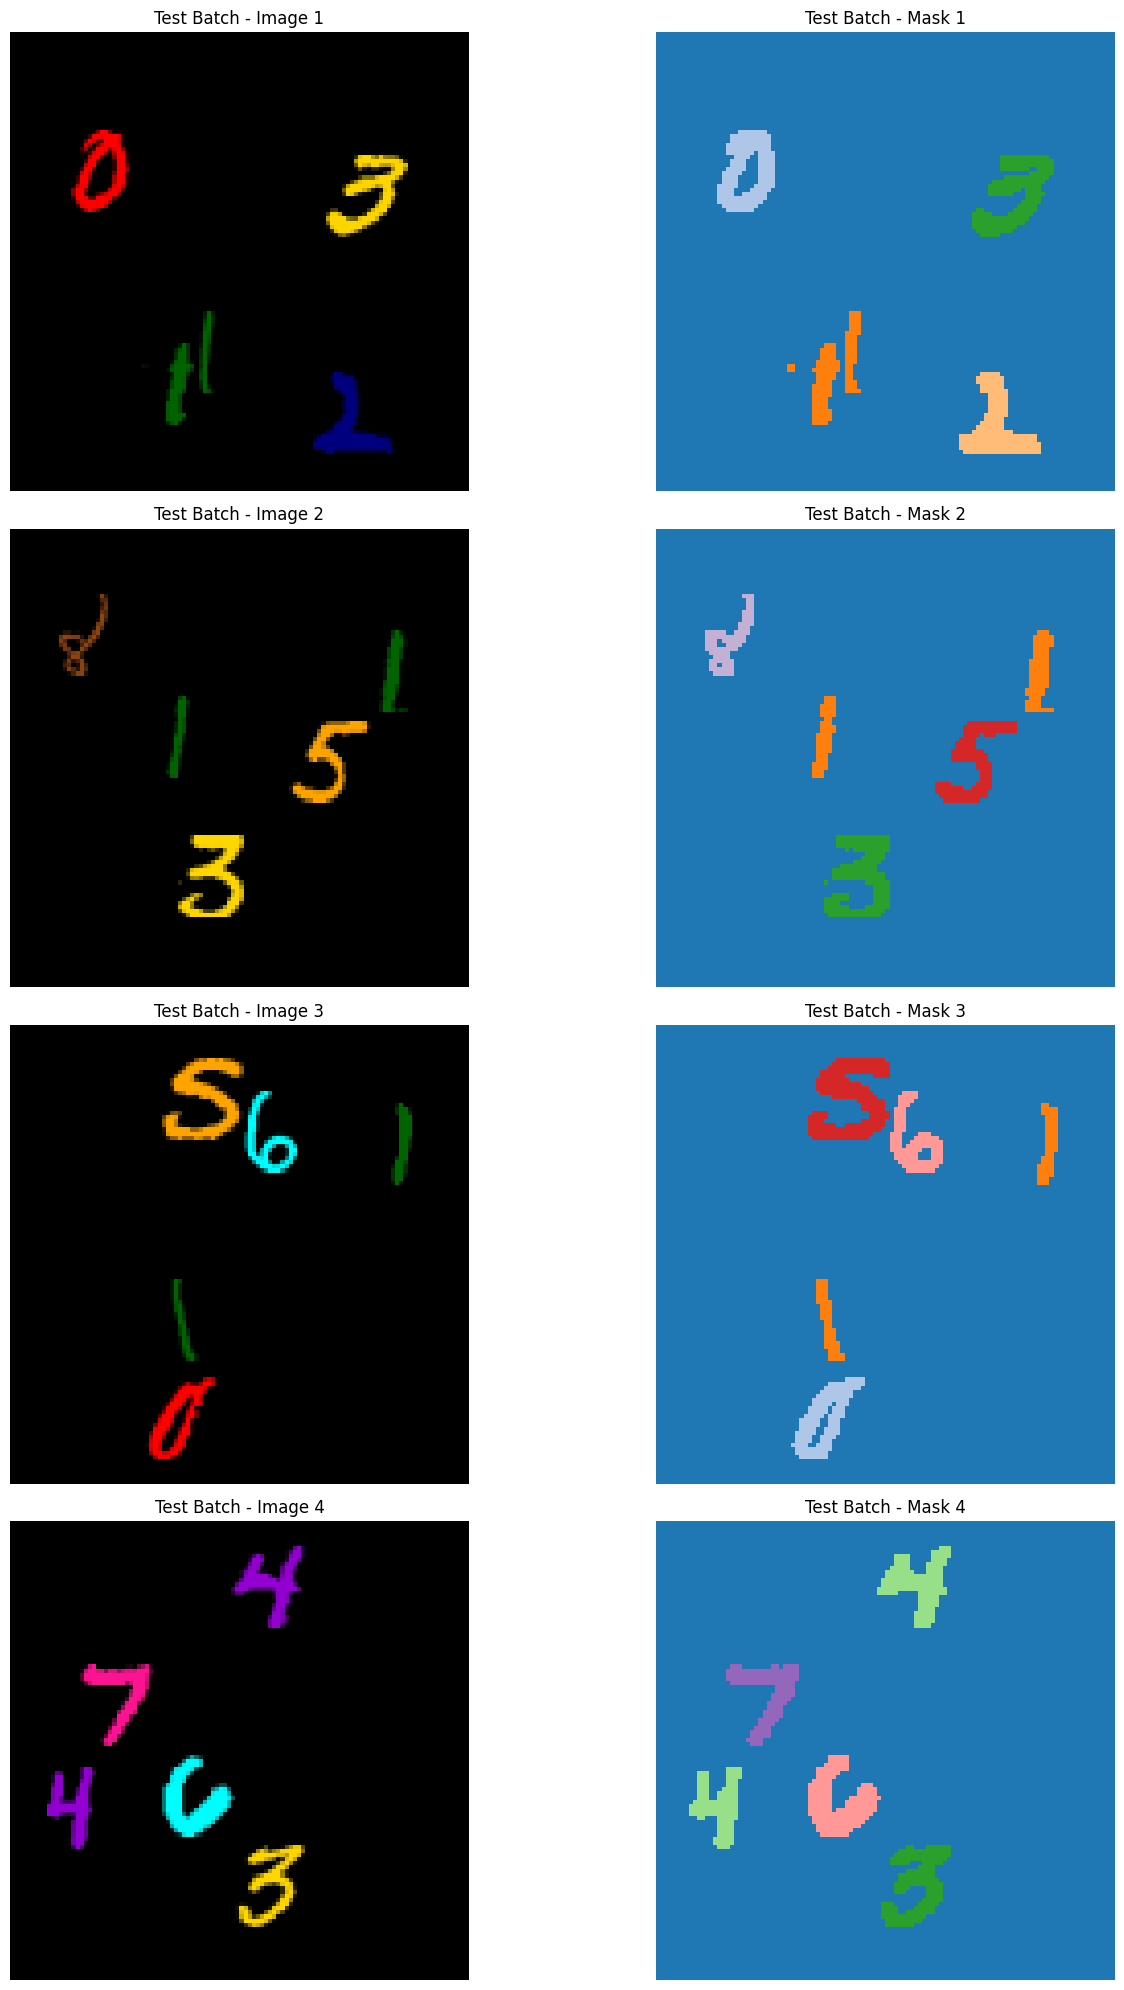

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(loader, title="Batch Samples", num_samples=4):
    """Visualize a batch of images and masks from a DataLoader"""
    # Get one batch
    images, masks = next(iter(loader))
    
    # Limit to num_samples for cleaner visualization
    images = images[:num_samples]
    masks = masks[:num_samples]
    
    plt.figure(figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Image (unnormalize if needed)
        img = images[i].numpy().transpose(1, 2, 0)
        img = img * 0.5 + 0.5  # Assuming normalization was (0.5, 0.5, 0.5)
        
        # Mask
        mask = masks[i].numpy()
        
        # Plot image
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"{title} - Image {i+1}")
        plt.axis('off')
        
        # Plot mask
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(mask, cmap='tab20', vmin=0, vmax=19)  # Using tab20 for better class distinction
        plt.title(f"{title} - Mask {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize batches from each loader
print("Training Batch Samples:")
show_batch(train_loader, "Train Batch")

print("\nValidation Batch Samples:")
show_batch(val_loader, "Val Batch")

print("\nTest Batch Samples:")
show_batch(test_loader, "Test Batch")

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [13]:
def compute_iou(preds, targets, num_classes):
    ious = []
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    for cls in range(1, num_classes):  # exclude background (class 0)
        pred_inds = preds == cls
        target_inds = targets == cls

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            ious.append(float('nan'))  # clase no presente en GT ni pred
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)  # mean IoU ignoring NaNs

## Arquitectura 1

In [24]:
class UNet(L.LightningModule):
    def __init__(self, in_channels=3, num_classes=11, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)  # [B, num_classes, H, W]

    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = F.cross_entropy(logits, masks)  
    
        preds = torch.argmax(logits, dim=1)
        iou = compute_iou(preds, masks, self.hparams.num_classes)

        if not torch.isfinite(loss):
            return None
        
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_iou", iou, prog_bar=True)  
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = F.cross_entropy(logits, masks)

        preds = torch.argmax(logits, dim=1)
        iou = compute_iou(preds, masks, self.hparams.num_classes)

        self.log("val_loss", loss)
        self.log("val_iou", iou, prog_bar=True)
        

    def test_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = F.cross_entropy(logits, masks)

        preds = torch.argmax(logits, dim=1)
        iou = compute_iou(preds, masks, self.hparams.num_classes)

        self.log("test_iou", iou, prog_bar=True)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [110]:
# Instancia del modelo (ya definido como clase UNet con PL)
model = UNet(in_channels=3, num_classes=11)

# Callbacks (early stopping + save best model)
early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
checkpoint = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")

# Logger
logger = CSVLogger(save_dir="logs/", name="colored_mnist_seg")

# Entrenador Lightning
trainer = L.Trainer(
    max_epochs=30,
    logger=logger,
    callbacks=[early_stop, checkpoint],
    accelerator="auto",  # usa GPU si está disponible
)

# Entrenamiento
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type            | Params | Mode 
--------------------------------------------------------
0  | enc1       | DoubleConv      | 10.1 K | train
1  | enc2       | DoubleConv      | 55.4 K | train
2  | enc3       | DoubleConv      | 221 K  | train
3  | enc4       | DoubleConv      | 885 K  | train
4  | pool       | MaxPool2d       | 0      | train
5  | bottleneck | DoubleConv      | 3.5 M  | train
6  | up4        | ConvTranspose2d | 524 K  | train
7  | dec4       | DoubleConv      | 1.8 M  | train
8  | up3        | ConvTranspose2d | 131 K  | train
9  | dec3       | DoubleConv      | 442 K  | train
10 | up2        | ConvTranspose2d | 32.8 K | train
11 | dec2       | DoubleConv      | 110 K  | train
12 | up1        | ConvTranspose2d | 8.2 K  | train
13 | dec1       | DoubleConv      | 27.7 K | train
14 | final_conv | C

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [111]:
# We verify the training using the validate method of the trainer object. The validate method returns the metrics for the validation dataset.
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

[{'val_loss': 0.004211694933474064, 'val_iou': 0.9755039215087891}]


In [112]:
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_iou': 0.9750277400016785, 'test_loss': 0.004193614237010479}]


,step,test_iou,test_loss,train_loss,val_iou,val_loss
epoch,,,,,,
0,1298.019608,NaN,NaN,0.018915,0.960144,0.006058
1,3798.019608,NaN,NaN,0.112863,0.918102,0.013547
2,6298.019608,NaN,NaN,0.009047,0.962279,0.006241
3,8798.019608,NaN,NaN,0.004780,0.978851,0.003793
4,11298.019608,NaN,NaN,0.003134,0.986114,0.002721
5,13798.019608,NaN,NaN,0.002650,0.988040,0.002166
6,16298.019608,NaN,NaN,0.001966,0.990324,0.001693
7,18798.019608,NaN,NaN,0.001852,0.992848,0.001323
8,21298.019608,NaN,NaN,0.011528,0.984111,0.002857


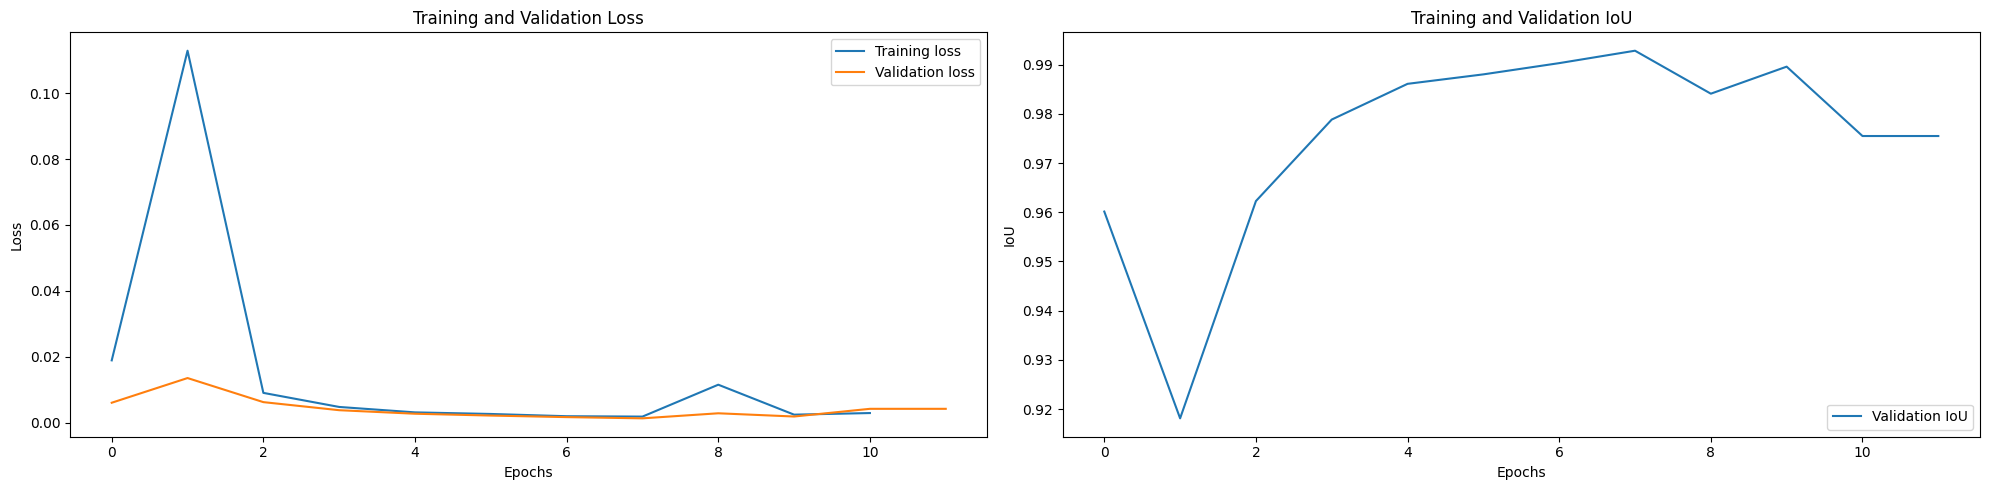

In [113]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

display(df_epochs)

# Create figures for loss and IoU
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot loss on first subplot
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(df_epochs['train_loss'], label="Training loss")
ax1.plot(df_epochs['val_loss'], label="Validation loss")
ax1.set_title("Training and Validation Loss")
ax1.legend(loc='upper right')

# Plot IoU on second subplot if available
if 'val_iou' in df_epochs.columns:
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    
    # Plot training IoU if available
    if 'train_iou' in df_epochs.columns:
        ax2.plot(df_epochs['train_iou'], label="Training IoU")
    
    ax2.plot(df_epochs['val_iou'], label="Validation IoU")
    ax2.set_title("Training and Validation IoU")
    ax2.legend(loc='lower right')
else:
    ax2.set_title("IoU not available in metrics")
    print("IoU metrics not found in the logged data")

plt.tight_layout()
plt.show()

In [23]:
# Cargar modelo desde un checkpoint
model = UNet.load_from_checkpoint("logs/colored_mnist_seg/version_3/checkpoints/epoch=7-step=20000.ckpt")


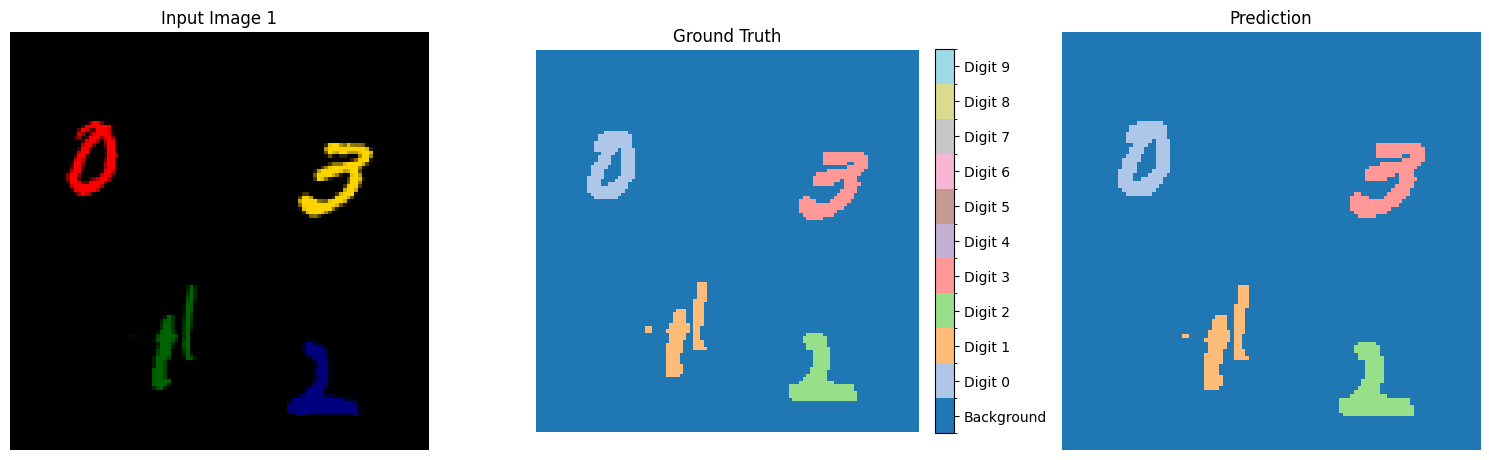

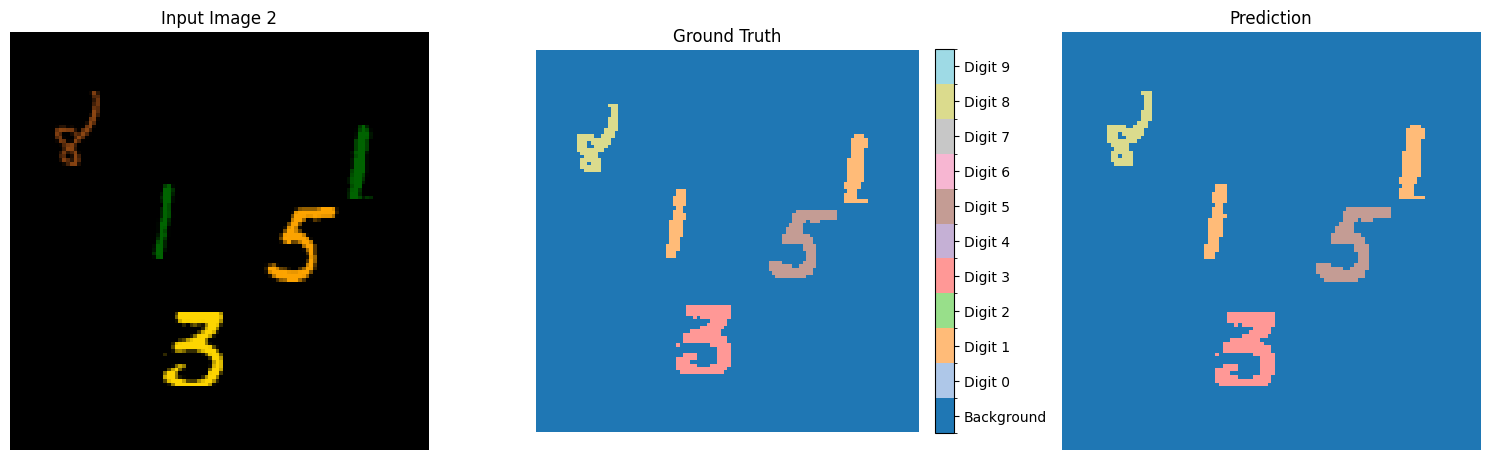

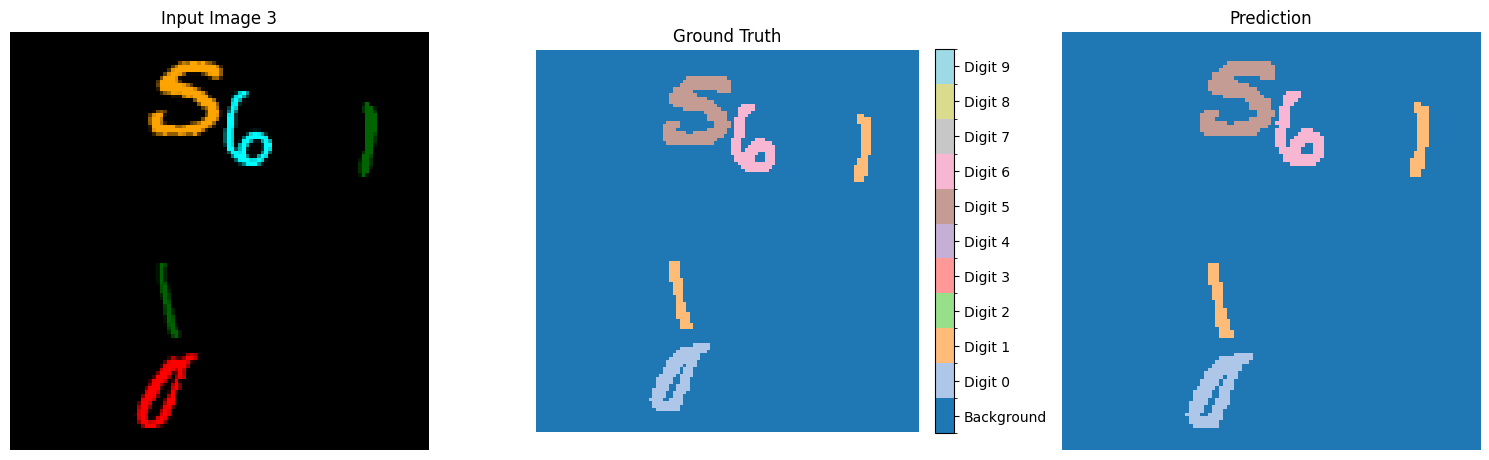

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions(model, test_loader, num_samples=3, figsize=(15, 5)):
    """Visualize model predictions with comparison to ground truth using correct colorbar."""
    model.eval()
    device = next(model.parameters()).device  # Get model device
    
    batch = next(iter(test_loader))
    images, gt_masks = batch
    images = images[:num_samples].to(device)
    gt_masks = gt_masks[:num_samples]
    
    with torch.no_grad():
        logits = model(images)
        pr_masks = logits.softmax(dim=1).argmax(dim=1).cpu()
    
    class_names = ["Background"] + [f"Digit {i}" for i in range(10)]  # 11 clases
    bounds = np.arange(12)  # [0, 1, ..., 11]
    norm = mcolors.BoundaryNorm(bounds, ncolors=20)  # tab20 = 20 colores

    for idx, (image, gt_mask, pr_mask) in enumerate(zip(images.cpu(), gt_masks, pr_masks)):
        plt.figure(figsize=figsize)
        
        # Input image
        plt.subplot(1, 3, 1)
        img_np = image.cpu().numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np * 0.5 + 0.5, 0, 1)
        plt.imshow(img_np)
        plt.title(f"Input Image {idx+1}")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(1, 3, 2)
        gt_np = gt_mask.cpu().numpy()
        im = plt.imshow(gt_np, cmap='tab20', norm=norm)
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Prediction
        plt.subplot(1, 3, 3)
        pr_np = pr_mask.cpu().numpy()
        plt.imshow(pr_np, cmap='tab20', norm=norm)
        plt.title("Prediction")
        plt.axis('off')

        # Colorbar
        cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
        cbar.set_ticks(np.arange(11) + 0.5)
        cbar.set_ticklabels(class_names)

        plt.tight_layout()
        plt.show()

# Usage
visualize_predictions(model, test_loader, num_samples=3)

In [29]:
def predict_and_show_single_image(model, image_path, image_size=112, normalized=True):
    """
    Carga una imagen, predice su máscara de segmentación y la visualiza.
    """
    model.eval()
    device = next(model.parameters()).device

    # === Preprocesamiento (igual que en entrenamiento) ===
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3) if normalized else transforms.Lambda(lambda x: x)
    ])
    
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # [1, C, H, W]

    with torch.no_grad():
        logits = model(image_tensor)
        pred_mask = logits.softmax(dim=1).argmax(dim=1).squeeze(0).cpu()  # [H, W]

    # === Visualización ===
    class_names = ["Background"] + [f"Digit {i}" for i in range(10)]
    bounds = np.arange(12)
    norm = mcolors.BoundaryNorm(bounds, ncolors=20)

    plt.figure(figsize=(10, 4))

    # Imagen original (desnormalizada si es necesario)
    plt.subplot(1, 2, 1)
    img_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    if normalized:
        img_np = img_np * 0.5 + 0.5
    plt.imshow(np.clip(img_np, 0, 1))
    plt.title("Original Image")
    plt.axis("off")

    # Máscara predicha
    plt.subplot(1, 2, 2)
    im = plt.imshow(pred_mask.numpy(), cmap='tab20', norm=norm)
    plt.title("Predicted Mask")
    plt.axis("off")

    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_ticks(np.arange(11) + 0.5)
    cbar.set_ticklabels(class_names)

    plt.tight_layout()
    plt.show()


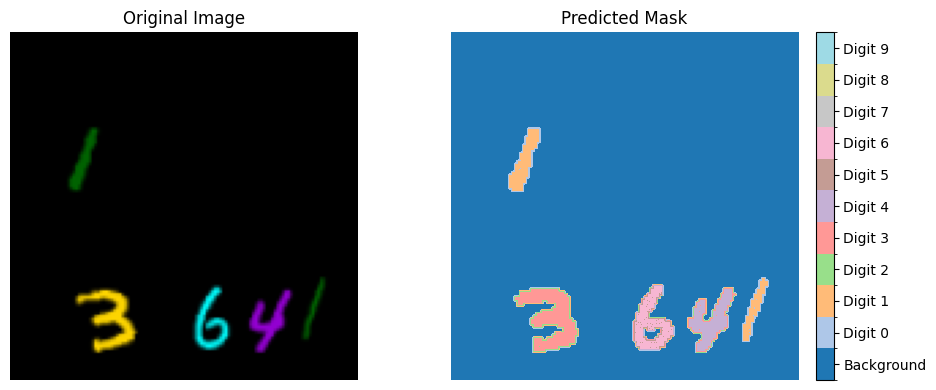

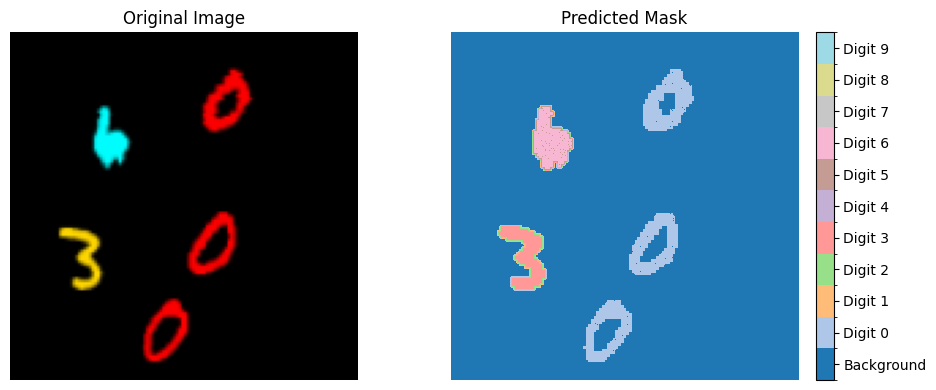

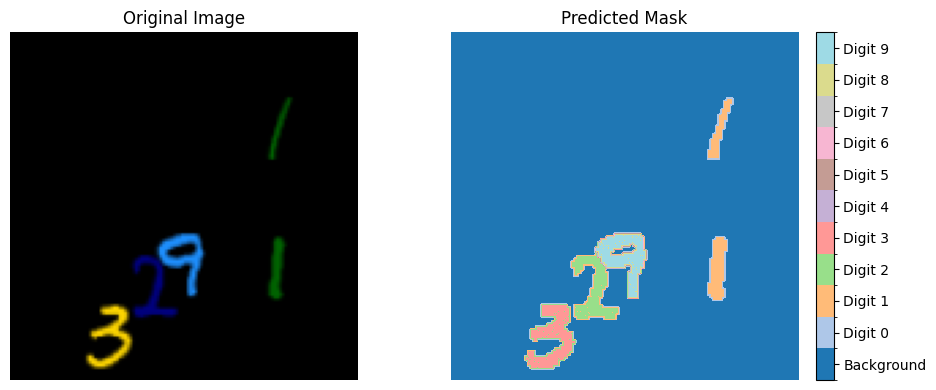

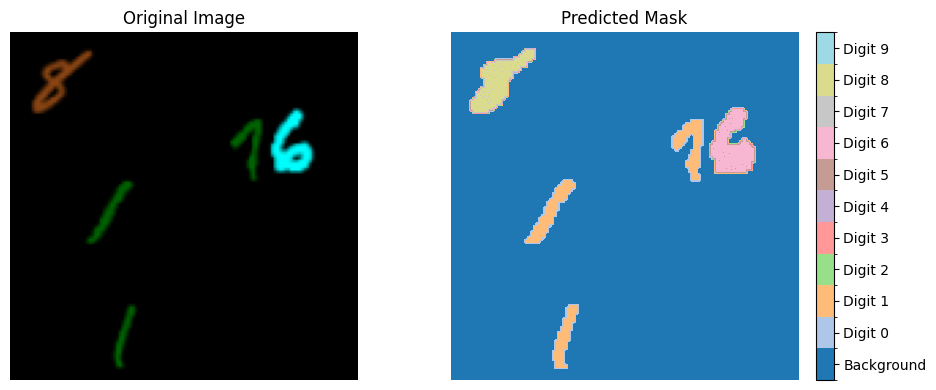

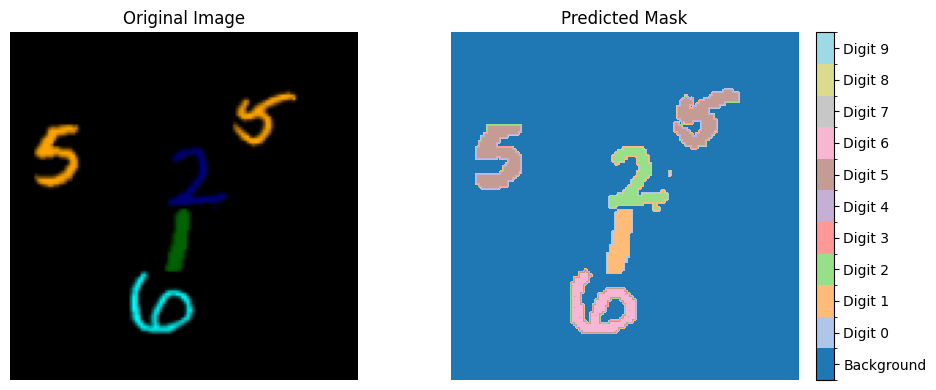

In [89]:
# Cargar modelo desde checkpoint
model = UNet.load_from_checkpoint("logs/colored_mnist_seg/version_3/checkpoints/epoch=7-step=20000.ckpt")
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Predecir y visualizar
for idx in range(5):
    predict_and_show_single_image(model, f"samples/img_{idx:04d}.png", image_size=128)


## Arquitectura 2

In [ ]:
class SegmentationDatasetLong(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_filenames[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, self.mask_filenames[idx]))

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        mask = mask.long()  # <-- Esta línea es clave

        return image, mask


In [57]:
img_transform = T.Compose([
    T.ToTensor(),  # Convierte [H, W, C] → [C, H, W]
    T.Normalize([0.5]*3, [0.5]*3),  # Normaliza RGB entre -1 y 1 (opcional)
])

mask_transform = T.Compose([
    T.PILToTensor(),  # da [1, H, W]
    T.Lambda(lambda x: x.squeeze(0)),  # Convierte [1, H, W] → [H, W]
])


In [ ]:
dataset = SegmentationDatasetLong("images", "masks", transform_img=img_transform, transform_mask=mask_transform)

In [59]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [61]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16,num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0)

In [63]:
def dice_loss(logits, targets, num_classes, smooth=1.0):
    logits = F.softmax(logits, dim=1)
    targets_onehot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    intersection = torch.sum(logits * targets_onehot, dim=(2, 3))
    union = torch.sum(logits + targets_onehot, dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return 1.0 - dice.mean()


def combo_loss(logits, targets, num_classes, alpha=0.5):
    ce = F.cross_entropy(logits, targets)
    dice = dice_loss(logits, targets, num_classes)
    return alpha * ce + (1 - alpha) * dice


In [64]:
class UNetComboLoss(L.LightningModule):
    def __init__(self, in_channels=3, num_classes=11, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)  # [B, num_classes, H, W]

    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = combo_loss(logits, masks, self.hparams.num_classes, alpha=0.5)

        preds = torch.argmax(logits, dim=1)
        iou = compute_iou(preds, masks, self.hparams.num_classes)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_iou", iou, prog_bar=True)  

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = combo_loss(logits, masks, self.hparams.num_classes, alpha=0.5)

        preds = torch.argmax(logits, dim=1)
        iou = compute_iou(preds, masks, self.hparams.num_classes)

        self.log("val_loss", loss)
        self.log("val_iou", iou, prog_bar=True)

        return
        

    def test_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss = combo_loss(logits, masks, self.hparams.num_classes)

        preds = torch.argmax(logits, dim=1)
        iou = compute_iou(preds, masks, self.hparams.num_classes)

        self.log("test_iou", iou, prog_bar=True)
        self.log("test_loss", loss)

        return

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [65]:
# Instancia del modelo (ya definido como clase UNet con PL)
model = UNetComboLoss(in_channels=3, num_classes=11)

# Callbacks (early stopping + save best model)
early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
checkpoint = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")

# Logger
logger = CSVLogger(save_dir="logs/", name="colored_mnist_seg")

# Entrenador Lightning
trainer = L.Trainer(
    max_epochs=30,
    logger=logger,
    callbacks=[early_stop, checkpoint],
    accelerator="auto",  # usa GPU si está disponible
)

# Entrenamiento
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type            | Params | Mode 
--------------------------------------------------------
0  | enc1       | DoubleConv      | 10.1 K | train
1  | enc2       | DoubleConv      | 55.4 K | train
2  | enc3       | DoubleConv      | 221 K  | train
3  | enc4       | DoubleConv      | 885 K  | train
4  | pool       | MaxPool2d       | 0      | train
5  | bottleneck | DoubleConv      | 3.5 M  | train
6  | up4        | ConvTranspose2d | 524 K  | train
7  | dec4       | DoubleConv      | 1.8 M  | train
8  | up3        | ConvTranspose2d | 131 K  | train
9  | dec3       | DoubleConv      | 442 K  | train
10 | up2        | ConvTranspose2d | 32.8 K | train
11 | dec2       | DoubleConv      | 110 K  | train
12 | up1        | ConvTranspose2d | 8.2 K  | train
13 | dec1       | DoubleConv      | 27.7 K | train
14 | final_conv | C

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [66]:
# We verify the training using the validate method of the trainer object. The validate method returns the metrics for the validation dataset.
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'val_loss': 0.009403995238244534, 'val_iou': 0.9582409262657166}]


In [67]:
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_iou': 0.9587417840957642, 'test_loss': 0.009388974867761135}]


,step,test_iou,test_loss,train_iou,train_loss,val_iou,val_loss
epoch,,,,,,,
0,1298.019608,NaN,NaN,0.856570,0.051585,0.925232,0.016871
1,3798.019608,NaN,NaN,0.938247,0.013514,0.947158,0.011509
2,6298.019608,NaN,NaN,0.957199,0.009323,0.968749,0.007601
3,8798.019608,NaN,NaN,0.871564,0.046604,0.927764,0.017757
4,11298.019608,NaN,NaN,0.937454,0.014446,0.944892,0.012371
5,13798.019608,NaN,NaN,0.952187,0.010879,0.958241,0.009404
6,15000.000000,0.958742,0.009389,NaN,NaN,0.958241,0.009404


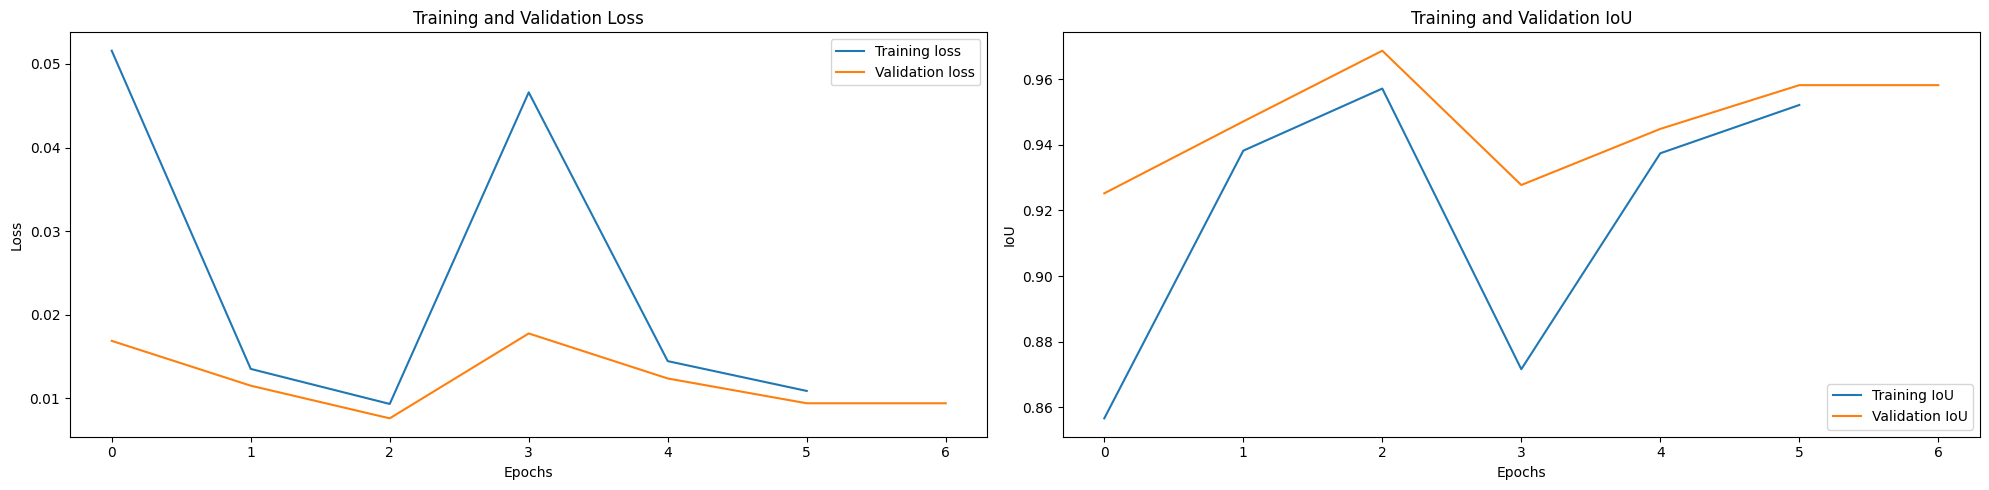

In [68]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

display(df_epochs)

# Create figures for loss and IoU
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot loss on first subplot
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(df_epochs['train_loss'], label="Training loss")
ax1.plot(df_epochs['val_loss'], label="Validation loss")
ax1.set_title("Training and Validation Loss")
ax1.legend(loc='upper right')

# Plot IoU on second subplot if available
if 'val_iou' in df_epochs.columns:
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    
    # Plot training IoU if available
    if 'train_iou' in df_epochs.columns:
        ax2.plot(df_epochs['train_iou'], label="Training IoU")
    
    ax2.plot(df_epochs['val_iou'], label="Validation IoU")
    ax2.set_title("Training and Validation IoU")
    ax2.legend(loc='lower right')
else:
    ax2.set_title("IoU not available in metrics")
    print("IoU metrics not found in the logged data")

plt.tight_layout()
plt.show()

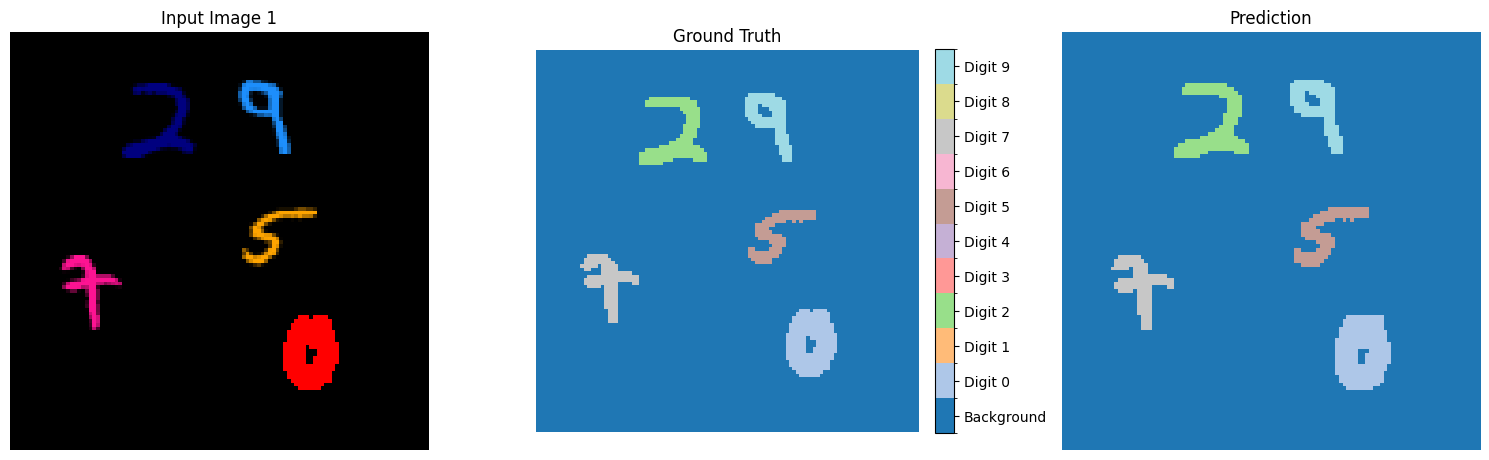

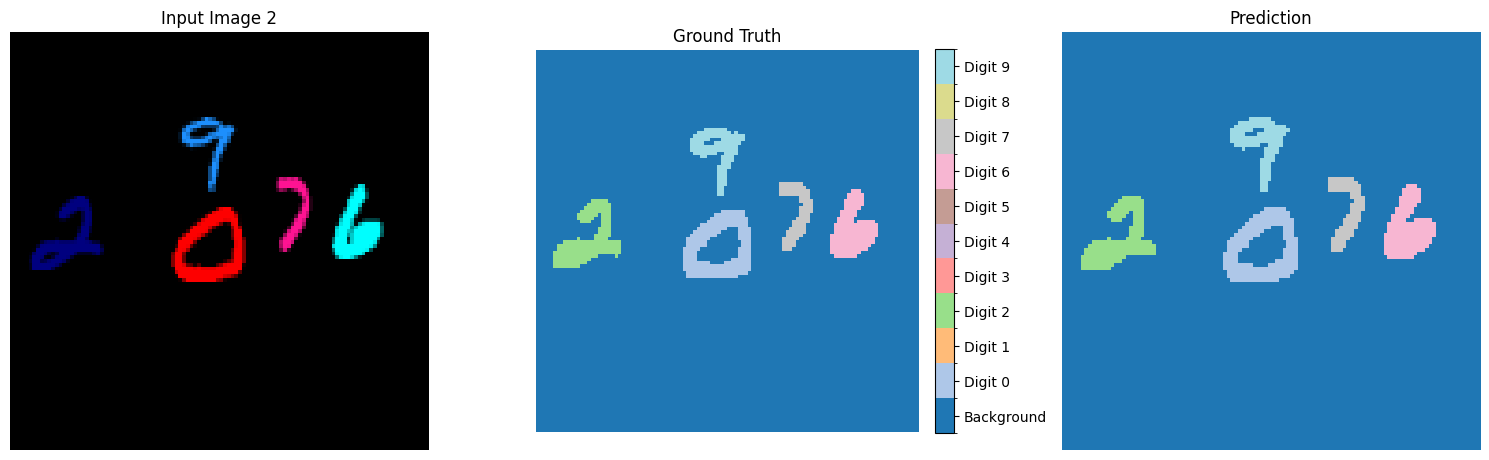

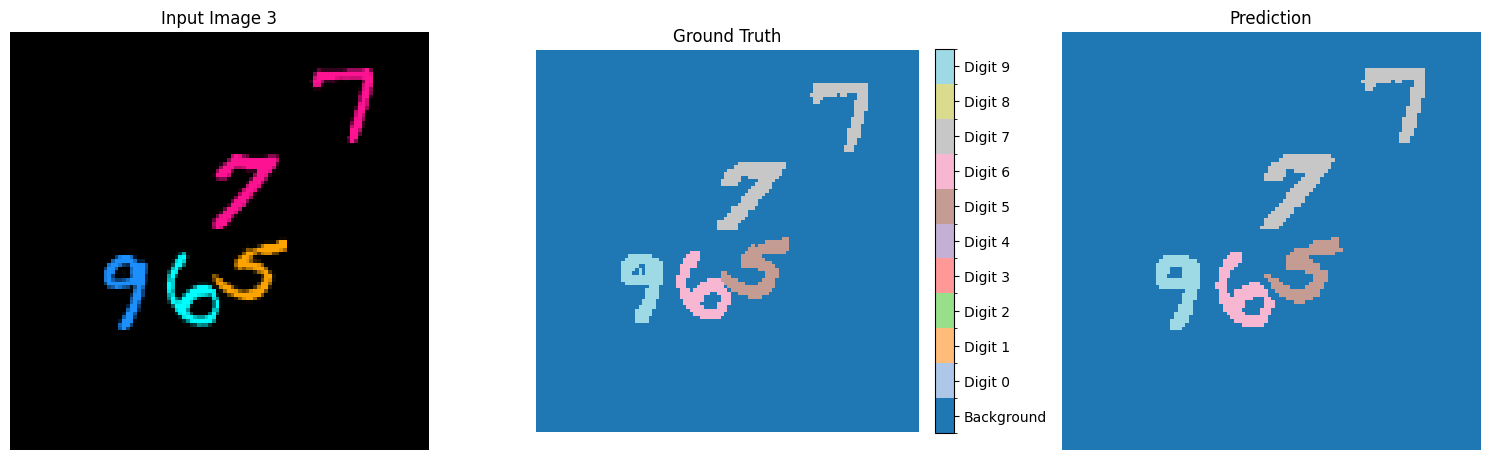

In [90]:
# Cargar modelo desde un checkpoint
model = UNetComboLoss.load_from_checkpoint("logs/colored_mnist_seg/version_9/checkpoints/epoch=2-step=7500.ckpt")
visualize_predictions(model, test_loader, num_samples=3)

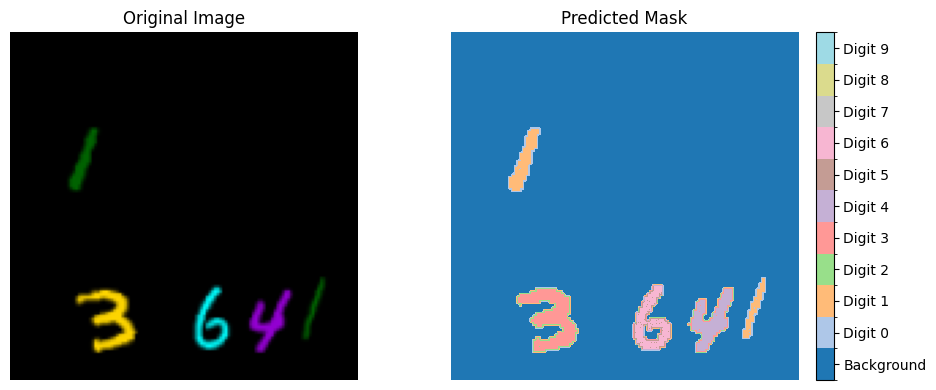

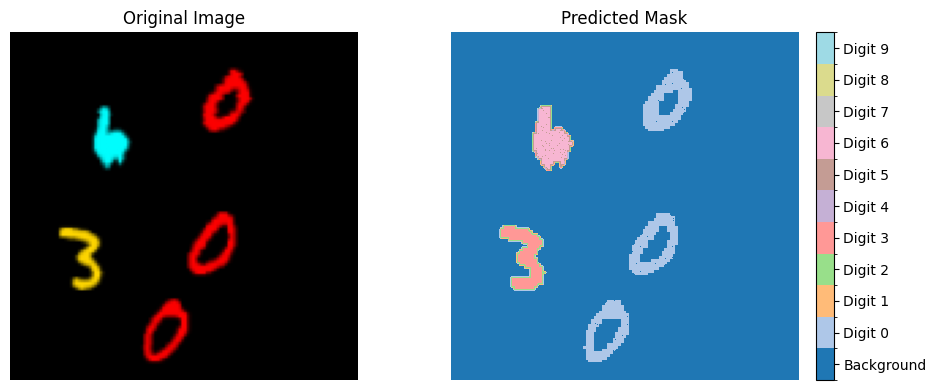

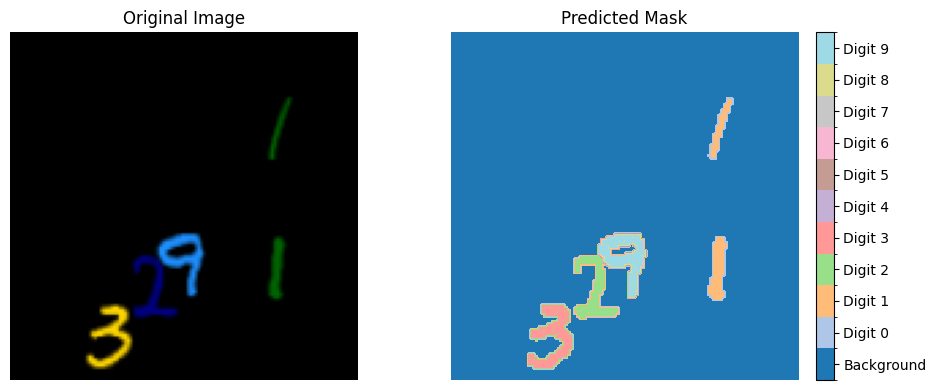

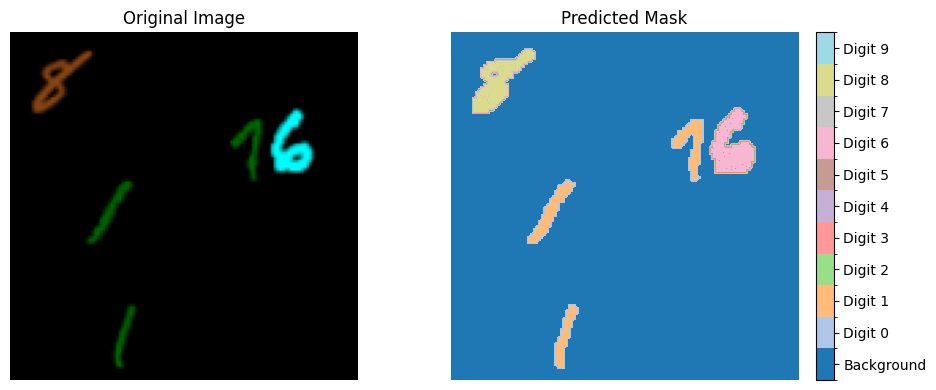

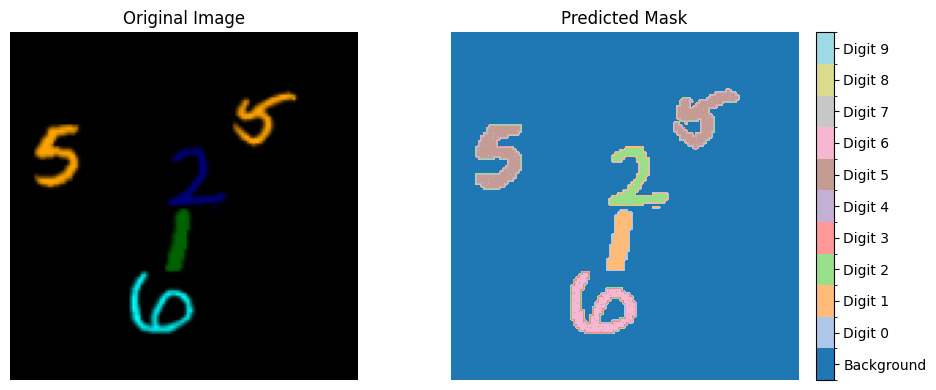

In [91]:
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Predecir y visualizar
for idx in range(5):
    predict_and_show_single_image(model, f"samples/img_{idx:04d}.png", image_size=128)